# Prediction of Credit Card Defaults 

Consumer credit default is a common problem for financial companies and, in 2020, global credit losses reached \\$900 billion (\\$200 billion of which occurred in the United States)[**](https://www.spglobal.com/ratings/en/research/articles/210202-lower-and-later-the-shifting-horizon-for-bank-credit-losses-11821801#:~:text=For%20banks%20across%20the%20globe,%242.1%20trillion%20in%20July%202020.). The ability to manage and model each customer's risk of default allows these financial companies to gain a competitive advantage in the financial services market and to preempt large losses by applying mitigation techniques such as risk-based pricing, purchasing credit insurance, tightening a borrower's credit limit, and/or diversifying the borrower pool.

Here I focus specifically on consumer *credit card* defaults and build a credit model to detect the likelihood that a customer defaults on their credit card in the following month. The data for this project comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) and contains 30,000 labeled instances of default/no default on Taiwanese credit card accounts in 2005.

**Goal:** Build a model to *predict* the *likelihood* of default, a model which can *generalize* to
other data points.

## Scoping the Problem

**Predict**: The goal specifies a need for a predictive model, not just descriptive analytics. This means that, on top of understanding the data, I will have to consider how to validate the model as well as choose appropriate metrics relevant to credit card default.

**Likelihood**: Another aspect to consider is building a model that outputs a likelihood (or percentage) of default, rather than a direct classification of default/no default. This is useful for the company to understand the actual risk level associated with customers and to guide business decisions.

**Generalize**: The model I build also needs to be able to generalize to new data so that it can be used to predict the likelihood of default for new credit lines in a production setting. This will likely include sectioning off a portion of the available data into a test set (and potentially performing cross-validation with a validation set) to avoid overfitting issues.

**Explainable**: Because the decisions based on this model can directly impact customer livelihood, it is important that the model is explainable in that the likelihood of default can be justified and the decision process is repeatable. Model explainability is also important for adhering to the guidelines created by financial regulatory bodies such as the Federal Trade Commission (FTC).

## Appropriate Model & Metrics

**Model**: I need to build a predictive model in the form of a binary classifier which fulfills the above requirements. In this case, a machine learning (ML) model would be more appropriate than a rule-based heuristic model because heuristic models, while very explainable, have problems generalizing to new data and providing likelihoods (without complex customization). I will investigate the performance of the following predictive ML models which output likelihoods, can generalize to new data, and are relatively explainable:
- **Logistic Regression**
- **Random Forest**
- **XGBoost**

**Metrics**: Because credit card defaults occur only a small percentage of the time in this dataset (22% of data is labeled as 'default'), accuracy would be a poor choice of metric since a classifier which only blindly predicts 'no default' will reach an accuracy of 78% yet have no true predictive power.

A more meaningful metric to consider is recall for the 'default' class because it focuses on reducing the number of false negatives in our predictions. In this context, a false negative occurs if our model predicts 'no default' when in reality the customer does default in the next month. This is very important (and detrimental) to financial institutions because it results in a much larger loss in funds than if I were to focus on minimizing false positives, which occur if our model predicts 'default' when in reality the customer does not default in the next month.

The main metric I will optimize for, however, is the area under the ROC curve which takes into account model performance over a broad range of threshold values for the classification decision function. I can compare relative model performance using the area under the ROC curve for each model. The ROC curve will also allow me to find the combination of model and cutoff threshold that results in high recall values. To summarize, the metrics I will investigate for each model in this problem are:
- **Recall of 'default' class**
- **Area under the ROC curve**

## Acquiring & Cleaning the Data

In [1]:
#Import all relevant packages used in this project

#Data
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

#Multiple Jupyter notebook outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, plot_roc_curve

In [2]:
#Install the xlrd package to download .xls files from a website URL directly and load the dataset

!pip install xlrd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
data = pd.read_excel(url, skiprows=[0], engine='xlrd')
print(data.shape)
data.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
#Drop ID column as it is only an identifier and shouldn't have predictive power

data.drop(['ID'], axis=1, inplace=True)

In [4]:
#Clean column names into lowercase

cols = data.columns
cols_lower = [col.lower() for col in cols]

I am **assuming** that the 'PAY_0' column name is a typo and that it represents payment status in September rather than October of 2005. It should then be changed to 'PAY_1' so that it directly relates to 'BILL_AMT1' and 'PAY_AMT1'. This should be a fair assumption because the repository describes that the pay, bill_amt, and pay_amt categories each have 6 columns corresponding to months prior to October 2005 (i.e. 'BILL_AMT1' = bill statement in September 2005, 'BILL_AMT2' = bill statement in August 2005, etc.).

In [5]:
#Rename columns
cols_lower[-1] = 'default'
cols_lower[5] = 'pay_1'

data.columns = cols_lower
data.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
#Look for missing data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   limit_bal  30000 non-null  int64
 1   sex        30000 non-null  int64
 2   education  30000 non-null  int64
 3   marriage   30000 non-null  int64
 4   age        30000 non-null  int64
 5   pay_1      30000 non-null  int64
 6   pay_2      30000 non-null  int64
 7   pay_3      30000 non-null  int64
 8   pay_4      30000 non-null  int64
 9   pay_5      30000 non-null  int64
 10  pay_6      30000 non-null  int64
 11  bill_amt1  30000 non-null  int64
 12  bill_amt2  30000 non-null  int64
 13  bill_amt3  30000 non-null  int64
 14  bill_amt4  30000 non-null  int64
 15  bill_amt5  30000 non-null  int64
 16  bill_amt6  30000 non-null  int64
 17  pay_amt1   30000 non-null  int64
 18  pay_amt2   30000 non-null  int64
 19  pay_amt3   30000 non-null  int64
 20  pay_amt4   30000 non-null  int64
 21  pay_amt5   3

In [7]:
#Show general statistics for numerical columns
#Note that in this case there is categorical data that was encoded numerically

data.describe()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


The general statistics for the columns seem reasonable and there are no obvious outliers (i.e. age range of 21-79 years old is reasonable). The dataset is imbalanced with respect to the target since only 22% of the data is labeled as 'default'. Three things I want to investigate further, some of which aren't explicitly defined in the repository, are:
- High limit balances: how many customers had high balances around 1 million New Taiwan dollars (NT)?
- Education categories of 4-6: are these common and do they have a strong correlation with default?
- Marriage category of 3: is this common and does it have a strong correlation with default?

The data does not have NULL values, however I do also want to check for duplicate entries. I am **assuming** that with the features presented in this data, the likelihood of exact duplicates are very low. It would be rare for two customers to have the exact same limit balance, education, age, and payment history in the 6 months being analyzed. Therefore, if the number of duplicate rows is relatively small, they can be safely deleted.

In [8]:
#Show the duplicate rows

print('Number of duplicate rows: %d' % (data.duplicated().sum()))
data[data.duplicated(keep=False)].sort_values(by=cols_lower)

Number of duplicate rows: 35


,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
12430,20000,1,2,2,24,2,2,4,4,4,4,1650,1650,1650,1650,1650,1650,0,0,0,0,0,0,1
14294,20000,1,2,2,24,2,2,4,4,4,4,1650,1650,1650,1650,1650,1650,0,0,0,0,0,0,1
1759,50000,1,2,2,26,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
10250,50000,1,2,2,26,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
7170,50000,2,1,2,23,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
17032,50000,2,1,2,23,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
7366,80000,2,2,1,31,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
19114,80000,2,2,1,31,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
21768,80000,2,2,2,25,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0
27765,80000,2,2,2,25,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
#Drop the duplicate rows

indices_to_drop = data[data.duplicated()].index
data.drop(indices_to_drop, axis=0, inplace=True)
data.shape

(29965, 24)

## Exploring & Understanding the Data

<AxesSubplot:xlabel='limit_bal', ylabel='Count'>

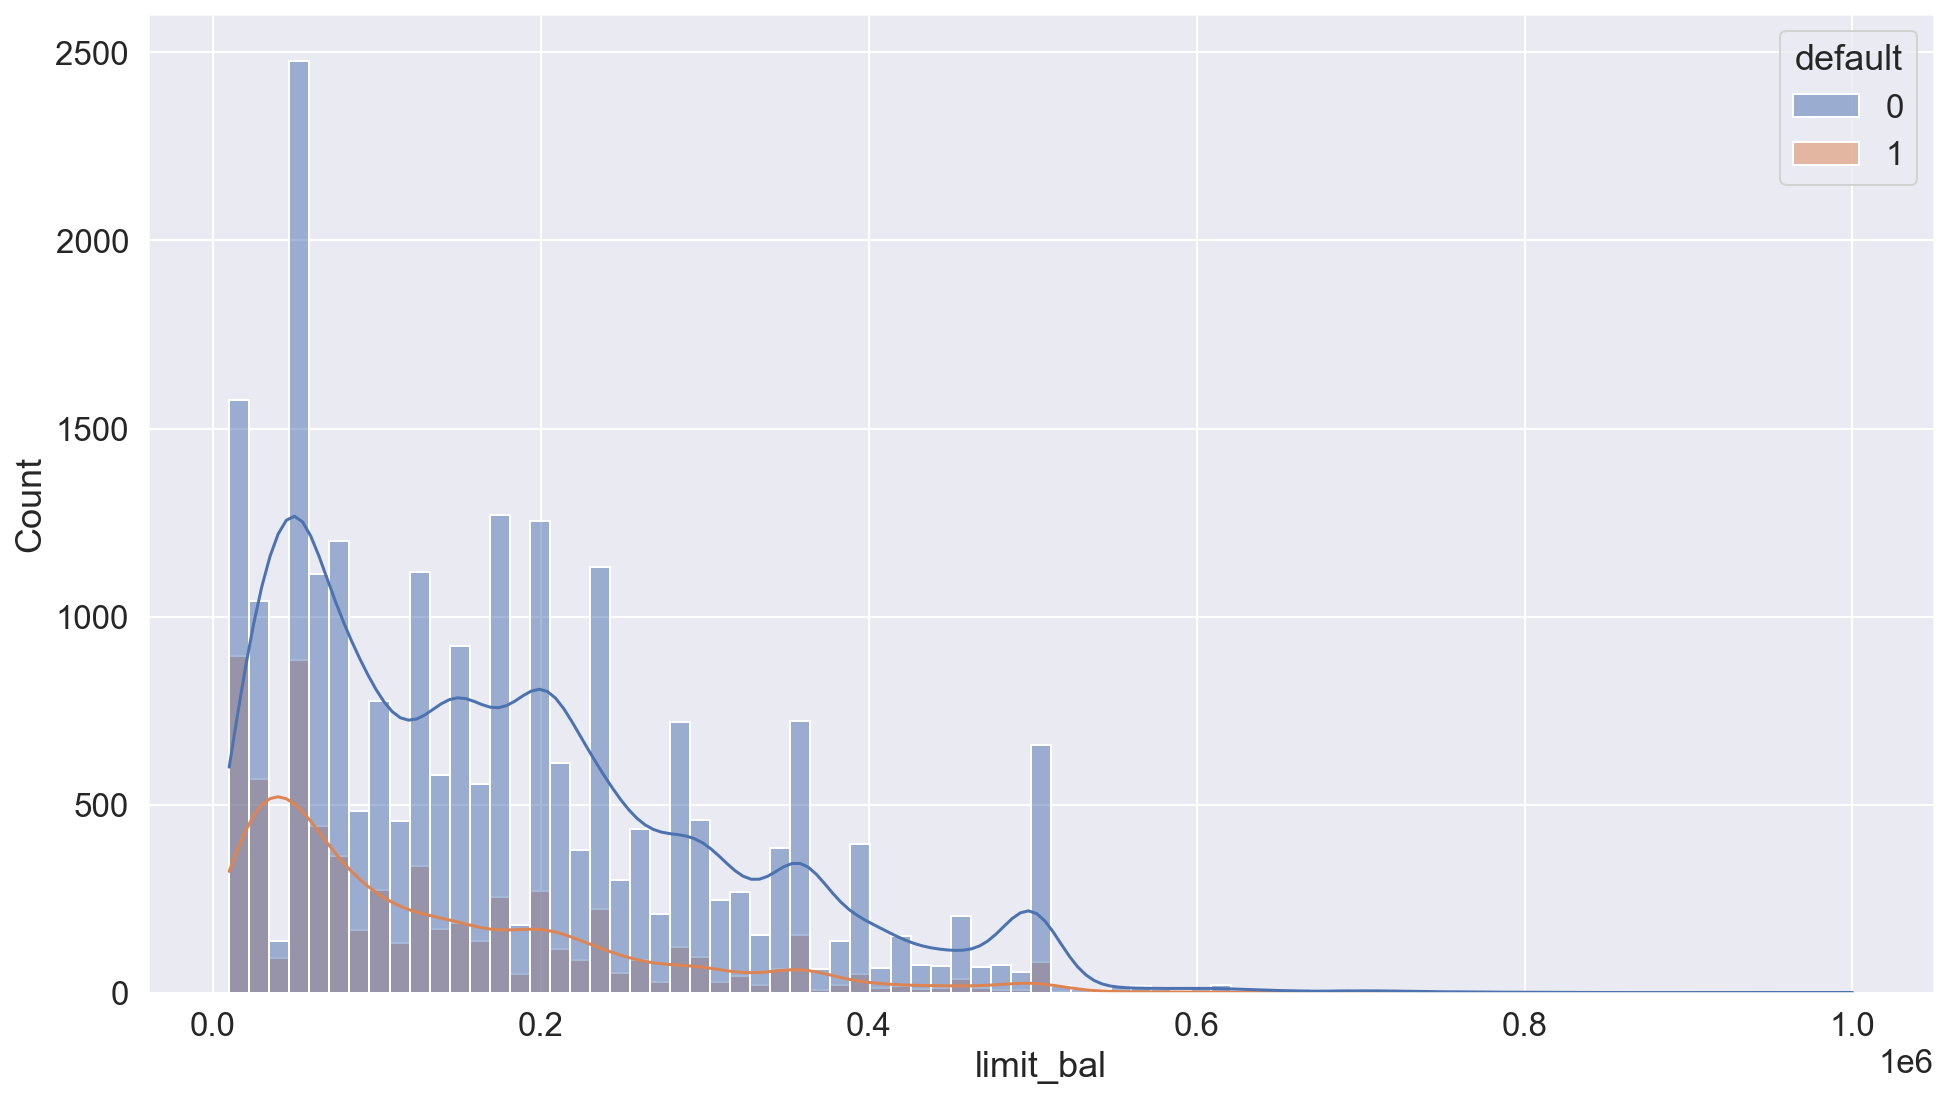

In [10]:
#Plot histogram of balances

sns.histplot(data, x='limit_bal', hue='default', kde=True)

For the limit balance, it may be useful to categorize the data into bins of roughly equal population in order to address the skewness of the data and to help evaluate different customers (i.e. low spenders vs. big spenders). Another approach could be to work in logarithmic space, but this would make explainability more difficult in later stages.

In [11]:
#Create 5 equally populated bins for limit balance
#Replace current numerical column with categorical

data['limit_bal_cat'] = pd.qcut(data['limit_bal'], 5, labels=[i for i in range(1,6)])
data.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,limit_bal_cat
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,3
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,2
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1


In [12]:
#One-hot encode limit balance category
#Keep numerical limit balance so that we can use it to potentially build other features

data = pd.concat([data, pd.get_dummies(data['limit_bal_cat'], prefix='limit_bal')], axis=1)
data.drop(['limit_bal_cat'], axis=1, inplace=True)
data.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,limit_bal_1,limit_bal_2,limit_bal_3,limit_bal_4,limit_bal_5
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,0


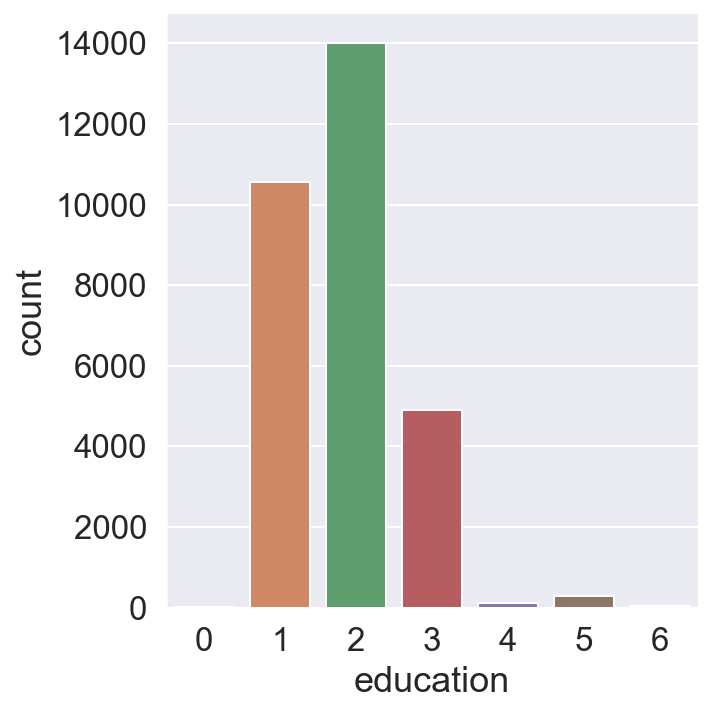

In [13]:
#Plot data for education

sns.catplot(x="education", data=data, kind="count");

In [14]:
data['education'].value_counts()

2    14019
1    10563
3     4915
5      280
4      123
6       51
0       14
Name: education, dtype: int64

For education, it may be useful to condense the categories since there are so few customers with 0, 4, 5, and 6 as their education. These education categories are also not defined by the data providers, however I **assume** that they follow the same numerical progression:
- 0: *Maybe medical school*
- 1: Graduate school
- 2: University
- 3: High School
- 4: *Maybe vocational/trade school*
- 5: *Maybe junior high school (Taiwan specific)*
- 6: *Maybe continuing/online school*

I will create 3 roughly equally populated education categories (high: 0-1, medium: 2, low: 3-6), since there is such a large imbalance for classes 0, 4, 5, and 6.

In [15]:
#Create 3 education bins

data.loc[(data['education'] < 2), 'education'] = 1
data.loc[(data['education'] == 2), 'education'] = 2
data.loc[(data['education'] > 2), 'education'] = 3

In [16]:
#One-hot encode education category

data = pd.concat([data, pd.get_dummies(data['education'], prefix='education')], axis=1)
data.rename(columns={"education_1": "education_high", "education_2": "education_med", "education_3": "education_low"}, inplace=True)
data.drop(['education'], axis=1, inplace=True)
data.head()

,limit_bal,sex,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,limit_bal_1,limit_bal_2,limit_bal_3,limit_bal_4,limit_bal_5,education_high,education_med,education_low
0,20000,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0,0,1,0
1,120000,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0,0,1,0
2,90000,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0,0,1,0
3,50000,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0,0,1,0
4,50000,1,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,0,0,1,0


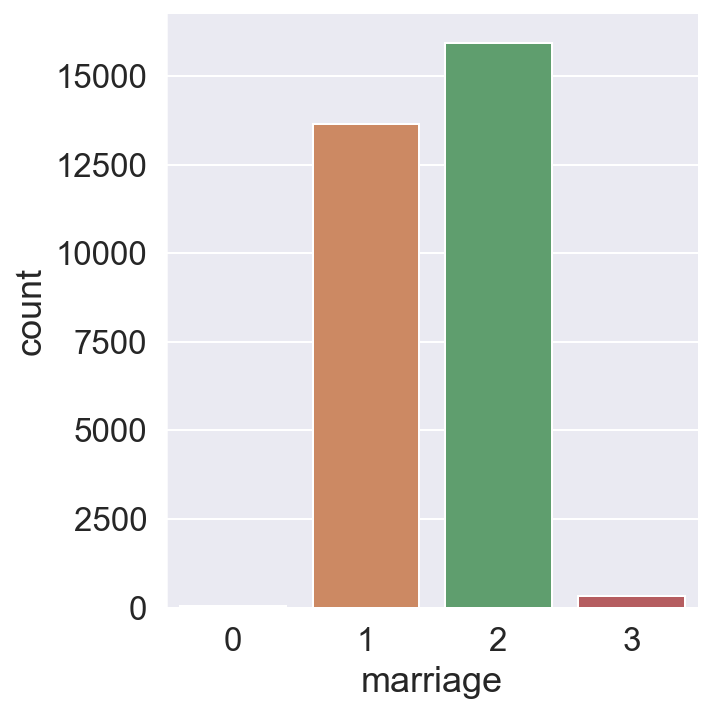

In [17]:
#Plot data for marriage

sns.catplot(x="marriage", data=data, kind="count");

In [18]:
data['marriage'].value_counts()

2    15945
1    13643
3      323
0       54
Name: marriage, dtype: int64

For marriage, most customers in the dataset fall under married: 1 or single: 2. The data providers only note that category 3 includes 'others'. I **assume** this could be for divorces and not same-sex marriage (because this was legally allowed in Taiwan far after 2005).

In terms of finances, a divorced person could be seen as similar to a married person due to continued family payments, alimony, child support, etc. A divorced person is also likely to be older, so if I find that people in marriage category 3 are relatively older, then I will place them in the married category. Otherwise, I will drop these rows from the dataset. I will also drop rows belonging to marriage category 0 since they are very rare and have no clear definition.

<AxesSubplot:xlabel='age', ylabel='Count'>

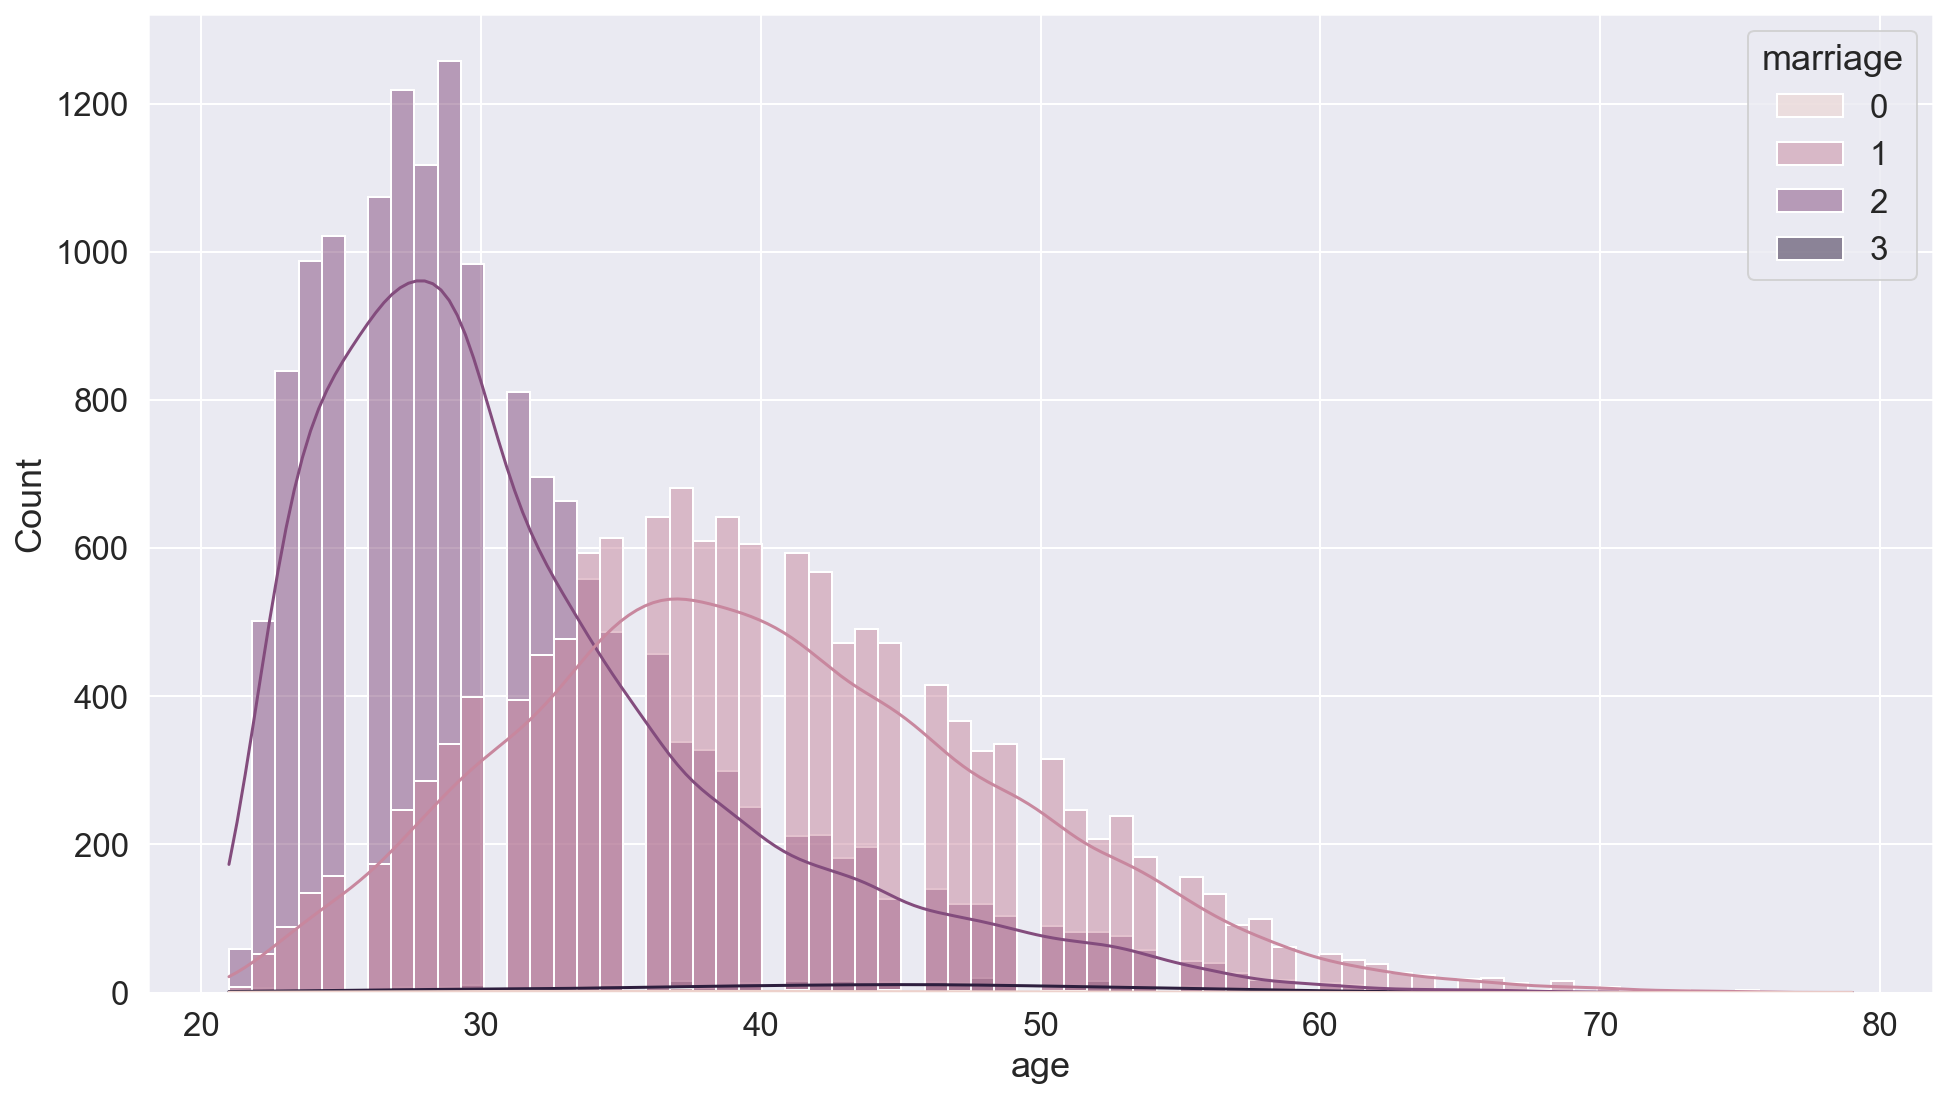

In [19]:
#Plot histogram of age ranges per marriage category

sns.histplot(data, x='age', hue='marriage', kde=True)

In [20]:
#Marriage category 3 age statistics (likely to be divorces)

data[data['marriage']==3]['age'].median()
data[data['marriage']==3]['age'].mean()

43.0

42.79876160990712

In [21]:
#Convert divorces to marriage and drop marriage category 0

data.loc[(data['marriage'] == 3), 'marriage'] = 1

indices_to_drop = data[data['marriage'] == 0].index
data.drop(indices_to_drop, axis=0, inplace=True)

In [22]:
#One-hot encode marriage category

data = pd.concat([data, pd.get_dummies(data['marriage'], prefix='marriage')], axis=1)
data.rename(columns={"marriage_1": "married", "marriage_2": "single"}, inplace=True)
data.drop(['marriage'], axis=1, inplace=True)
data.head()

,limit_bal,sex,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,limit_bal_1,limit_bal_2,limit_bal_3,limit_bal_4,limit_bal_5,education_high,education_med,education_low,married,single
0,20000,2,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0
1,120000,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0,0,1,0,0,1
2,90000,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0,0,1,0,0,1
3,50000,2,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0,0,1,0,1,0
4,50000,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,0,0,1,0,1,0


The sex category has two values male: 1 and female: 2. They are already close in proportion so I simply one-hot encode this column.

In [23]:
#One-hot encode sex category

data['sex'].value_counts()

data = pd.concat([data, pd.get_dummies(data['sex'], prefix='sex')], axis=1)
data.rename(columns={"sex_1": "male", "sex_2": "female"}, inplace=True)
data.drop(['sex'], axis=1, inplace=True)
data.head()

2    18051
1    11860
Name: sex, dtype: int64

,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,limit_bal_1,limit_bal_2,limit_bal_3,limit_bal_4,limit_bal_5,education_high,education_med,education_low,married,single,male,female
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1
1,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0,0,1,0,0,1,0,1
2,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0,0,1,0,0,1,0,1
3,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0,0,1,0,1,0,0,1
4,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,0,0,1,0,1,0,1,0


<AxesSubplot:xlabel='age', ylabel='Count'>

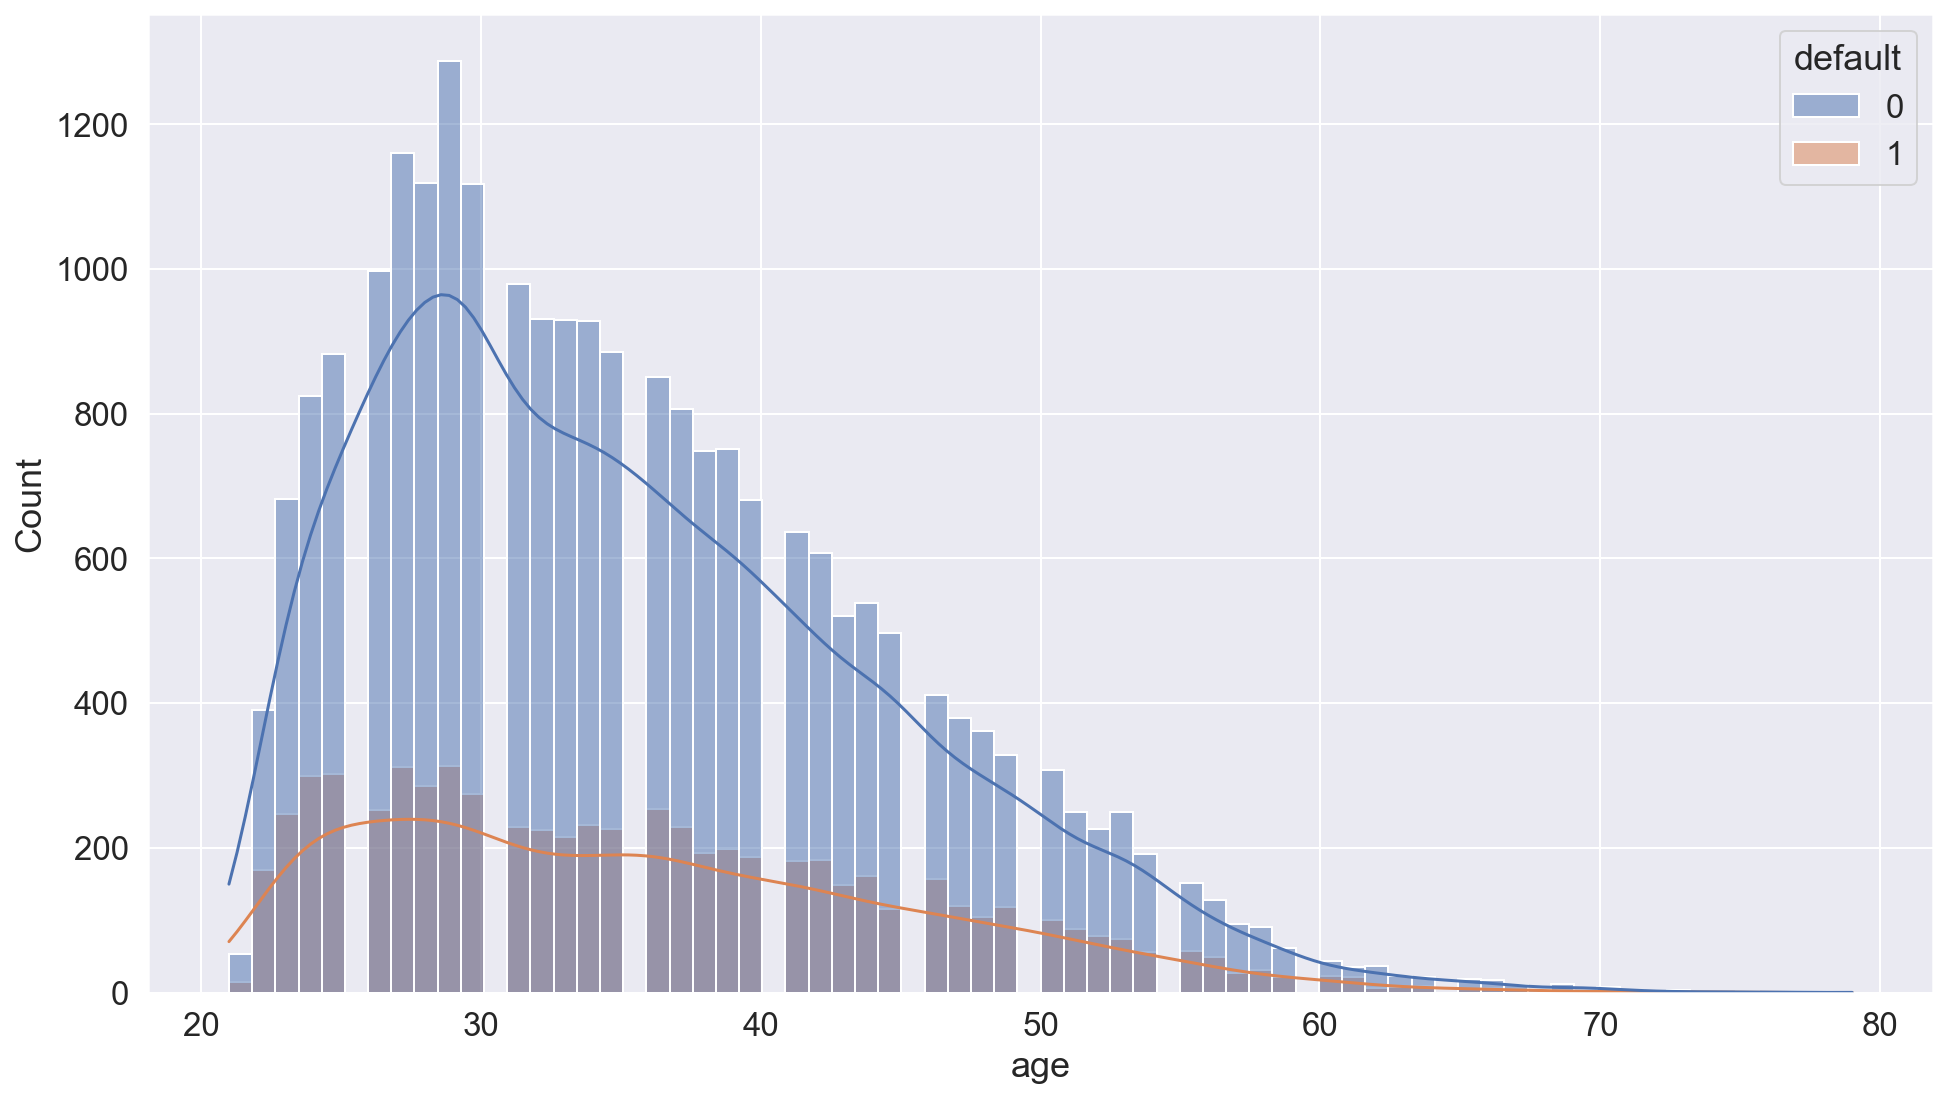

In [24]:
#Plot histogram of customer age

sns.histplot(data, x='age', hue='default', kde=True)

This dataset contains a good spread of age ranges. It looks like most defaults occur with younger customers, however the proportion of default to no default increases with age. Both of these pieces of information need to be considered for business decisions regarding profitability.

Here I will bin the customer ages into 3 categories, which I **assume** correspond to the 3 stages of a typical student or working citizen's career lifecycle. Ages 20-30 typically include students and young professionals beginning careers. Ages 30-50 typically include industry professionals with families. Ages 50+ typically include people at the end of their careers or retirees.

In [25]:
#Create 3 age bins

data.loc[(data['age'] <= 30), 'age'] = 1
data.loc[(data['age'] > 30) & (data['age'] <= 50), 'age'] = 2
data.loc[(data['age'] > 50), 'age'] = 3

In [26]:
#One-hot encode age category

data['age'].value_counts()

data = pd.concat([data, pd.get_dummies(data['age'], prefix='age')], axis=1)
data.rename(columns={"age_1": "age_young", "age_2": "age_med", "age_3": "age_old"}, inplace=True)
data.drop(['age'], axis=1, inplace=True)
data.head()

2    16662
1    10985
3     2264
Name: age, dtype: int64

,limit_bal,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,limit_bal_1,limit_bal_2,limit_bal_3,limit_bal_4,limit_bal_5,education_high,education_med,education_low,married,single,male,female,age_young,age_med,age_old
0,20000,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0
1,120000,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0
2,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0
3,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0
4,50000,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1


The pay_* columns describe the customer's repayment status for that given month. Positive numbers indicate the number of months that a payment has been delayed, while -1 indicates a duly paid status. I will convert the -1 into 0 so that it can be more easily interpreted as 'no payment delay'. It is not clear what -2 would mean in this context so I will combine these into the entries with 0.

In [27]:
#Replace -2 in pay columns with 0, since they are likely still in good standing for that month

data[['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']] = data[['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].replace([-2, -1], 0)

In [28]:
data.head()

,limit_bal,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,limit_bal_1,limit_bal_2,limit_bal_3,limit_bal_4,limit_bal_5,education_high,education_med,education_low,married,single,male,female,age_young,age_med,age_old
0,20000,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0
1,120000,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0
2,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0
3,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0
4,50000,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1


## Feature Engineering

Now that the given data is cleaned and encoded numerically, it is useful to consider engineering features that could potentially have predictive power. This typically requires understanding customer behavior and having some domain knowledge. In this case, a few features that come to mind for someone's personal finances include:

- % increase in bill amount from previous months
- % increase in payment amount from previous months
- Ratio of payment amount / bill amount each month
- Ratio of bill amount / limit balance each month
- Ratio of payment amount / limit balance each month
- Did customer have payment delay for 2+ months in the last 6 months?
- Does customer have a payment history?
- Is customer young with a large bill amount last month?
- Is customer old with a large limit balance?

I will create these features and add them to the dataframe. I can then perform rounds of feature selection (e.g. logistic regression with L1 regularization) to determine those features with strong predictive power.

In [29]:
#Percent increase in bill amount from previous months
#Entries with zero will cause numerical problems, so I will mark those as 0% increase

for i in range(1,6):
    new_col = 'ratio_prev_bill_{}'.format(i)
    bill_col1 = 'bill_amt{}'.format(i)
    bill_col2 = 'bill_amt{}'.format(i+1)
    
    data[new_col] = (data[bill_col1] / data[bill_col2]).round(2)
    data[new_col] = data[new_col].replace([np.inf, -np.inf, np.nan], 0)

In [30]:
#Percent increase in payment amount from previous months
#Entries with zero will cause numerical problems, so I will mark those as 0% increase

for i in range(1,6):
    new_col = 'ratio_prev_pay_{}'.format(i)
    pay_col1 = 'pay_amt{}'.format(i)
    pay_col2 = 'pay_amt{}'.format(i+1)
    
    data[new_col] = (data[pay_col1] / data[pay_col2]).round(2)
    data[new_col] = data[new_col].replace([np.inf, -np.inf, np.nan], 0)

In [31]:
#Ratio of payment amount / bill amount each month
#Entries with zero will cause numerical problems, so I will mark those as 0% increase

for i in range(1,7):
    new_col = 'ratio_pay_bill_{}'.format(i)
    col1 = 'pay_amt{}'.format(i)
    col2 = 'bill_amt{}'.format(i)
    
    data[new_col] = (data[col1] / data[col2]).round(2)
    data[new_col] = data[new_col].replace([np.inf, -np.inf, np.nan], 0)

In [32]:
#Ratio of bill amount / limit balance each month
#Limit balances are all positive and greater than zero, so should be no numerical problems

for i in range(1,7):
    new_col = 'ratio_bill_bal_{}'.format(i)
    col1 = 'bill_amt{}'.format(i)
    col2 = 'limit_bal'

    data[new_col] = (data[col1] / data[col2]).round(2)


In [33]:
#Ratio of payment amount / limit balance each month
#Limit balances are all positive and greater than zero, so should be no numerical problems

for i in range(1,7):
    new_col = 'ratio_pay_bal_{}'.format(i)
    col1 = 'pay_amt{}'.format(i)
    col2 = 'limit_bal'

    data[new_col] = (data[col1] / data[col2]).round(2)


In [34]:
#Did customer have payment delay for 2+ months in the last 6 months?

data['delayed_customer'] = np.select( \
                                     [data['pay_1'] > 1, data['pay_2'] > 1, data['pay_3'] > 1, \
                                      data['pay_4'] > 1, data['pay_5'] > 1, data['pay_6'] > 1, ], \
                                     [1, 1, 1, 1, 1, 1], default=0)

In [35]:
#Does customer have a payment history?
#If they dont have bill amounts or payment amounts in the last 6 months, then maybe they should be dropped.
#This is because if they aren't actively using their credit line, they should not be at risk of default in that next month.

bill_cols = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
zero_bills = data.loc[(data[bill_cols]==0).all(axis=1)]
data.drop(zero_bills.index, axis=0, inplace=True)

pay_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
zero_pays = data.loc[(data[pay_cols]==0).all(axis=1)]
data.drop(zero_pays.index, axis=0, inplace=True)

In [36]:
#Is customer young with a large bill last month?
#I will use the median of bill_amt1 as an indicator for a 'large bill'.
#This seems reasonable because young people with more than a standard bill may have trouble repaying

data['young_large_bill'] = np.where((data['age_young'] == 1) & (data['bill_amt1'] > data['bill_amt1'].median()), 1, 0)

In [37]:
#Is customer old with a large limit balance?

data['old_large_bal'] = np.where((data['age_old'] == 1) & (data['limit_bal_5'] == 1), 1, 0)

In [38]:
data.shape
data.head()

(28444, 66)

,limit_bal,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,limit_bal_1,limit_bal_2,limit_bal_3,limit_bal_4,limit_bal_5,education_high,education_med,education_low,married,single,male,female,age_young,age_med,age_old,ratio_prev_bill_1,ratio_prev_bill_2,ratio_prev_bill_3,ratio_prev_bill_4,ratio_prev_bill_5,ratio_prev_pay_1,ratio_prev_pay_2,ratio_prev_pay_3,ratio_prev_pay_4,ratio_prev_pay_5,ratio_pay_bill_1,ratio_pay_bill_2,ratio_pay_bill_3,ratio_pay_bill_4,ratio_pay_bill_5,ratio_pay_bill_6,ratio_bill_bal_1,ratio_bill_bal_2,ratio_bill_bal_3,ratio_bill_bal_4,ratio_bill_bal_5,ratio_bill_bal_6,ratio_pay_bal_1,ratio_pay_bal_2,ratio_pay_bal_3,ratio_pay_bal_4,ratio_pay_bal_5,ratio_pay_bal_6,delayed_customer,young_large_bill,old_large_bal
0,20000,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1.26,4.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.00,0.20,0.16,0.03,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,1,0,0
1,120000,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1.55,0.64,0.82,0.95,1.06,0.00,1.00,1.00,0.00,0.00,0.00,0.58,0.37,0.31,0.00,0.61,0.02,0.01,0.02,0.03,0.03,0.03,0.00,0.01,0.01,0.01,0.00,0.02,1,0,0
2,90000,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,2.08,1.03,0.95,0.96,0.96,1.01,1.50,1.00,1.00,0.20,0.05,0.11,0.07,0.07,0.07,0.32,0.32,0.16,0.15,0.16,0.17,0.17,0.02,0.02,0.01,0.01,0.01,0.06,0,0,0
3,50000,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0.97,0.98,1.74,0.98,0.98,0.99,1.68,1.09,1.03,1.07,0.04,0.04,0.02,0.04,0.04,0.03,0.94,0.96,0.99,0.57,0.58,0.59,0.04,0.04,0.02,0.02,0.02,0.02,0,0,0
4,50000,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1.52,0.16,1.71,1.09,1.00,0.05,3.67,1.11,13.06,1.01,0.23,6.47,0.28,0.43,0.04,0.04,0.17,0.11,0.72,0.42,0.38,0.38,0.04,0.73,0.20,0.18,0.01,0.01,0,0,0


I am happy with these features, although 66 features could be troublesome in terms of model training time. If training takes too long I can also consider removing the most historical data in a sequential manner (i.e. remove data from 6 months ago, then remove data from 5 months ago, etc. until training time improves). The **assumption** would be that the features closer in time to the default/no default prediction are more important because people can change their personal finance habits over such a timespan.

The last steps in this section will be to:
- Remove the 'limit_bal' feature since it is already encoded and has been used to engineer new features.
- Scale the bill amount and payment amount columns so that they can be modeled for feature selection.
- Finally, analyze feature importance using regularized logistic regression to fine-tune the features that will go into the final model.

In [39]:
#Remove limit_bal feature

data.drop(['limit_bal'], axis=1, inplace=True)

In [40]:
#Scale the bill amount columns
#I will use the standard scaler rather than minmax scaler here since some bill amounts can also be negative (pay forward credit)

for col in bill_cols:
    scaler = StandardScaler()
    scaled_col = scaler.fit_transform(data[col].values.reshape(-1,1))
    data[col] = pd.Series(scaled_col.flatten(), index=data.index, name=col)

In [41]:
#Scale the payment amount columns
#I will use the minmax scaler rather than standard scaler here since all payment amounts are positive
for col in pay_cols:
    scaler = MinMaxScaler()
    scaled_col = scaler.fit_transform(data[col].values.reshape(-1,1))
    data[col] = pd.Series(scaled_col.flatten(), index=data.index, name=col)

## Feature Selection

In [42]:
#Set up logistic regression with L1 (Lasso) regularization
X = data.drop(['default'], axis=1)
y = data['default']

clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(X, y)

LogisticRegression(penalty='l1', solver='liblinear')

In [43]:
#Create feature importance dataframe
#Examine feature importance and decide what to keep/throw

coefs = pd.DataFrame(clf.coef_[0], columns=['feature_importance'])
coefs['feature'] = X.columns
coefs_sorted = coefs.sort_values(by='feature_importance', ascending=False, ignore_index=True)

#10 most important features which are positively related to default
coefs_sorted.head(10)

#10 most important features which are negatively related to default
coefs_sorted.tail(10)

,feature_importance,feature
0,0.800032,delayed_customer
1,0.722942,pay_1
2,0.237680,ratio_bill_bal_3
3,0.187021,limit_bal_1
4,0.173966,ratio_bill_bal_6
5,0.100654,pay_5
6,0.100590,ratio_bill_bal_4
7,0.099683,old_large_bal
8,0.088152,ratio_bill_bal_2
9,0.084229,pay_6


,feature_importance,feature
54,-0.355911,limit_bal_4
55,-0.377292,ratio_pay_bal_5
56,-0.385150,ratio_bill_bal_5
57,-0.540111,single
58,-0.559698,limit_bal_5
59,-0.572472,male
60,-0.681664,female
61,-1.011915,ratio_pay_bal_2
62,-1.012215,pay_amt6
63,-6.079580,pay_amt1


Since model training only took 3.7 seconds (for logistic regression), I won't worry about removing many features. I will only remove those features which had abs(feature_importance) < 0.05 since they are likely not to hold predictive power.

In [44]:
coefs_sorted = coefs_sorted[np.abs(coefs_sorted['feature_importance']) > 0.05]
coefs_sorted

,feature_importance,feature
0,0.800032,delayed_customer
1,0.722942,pay_1
2,0.237680,ratio_bill_bal_3
3,0.187021,limit_bal_1
4,0.173966,ratio_bill_bal_6
5,0.100654,pay_5
6,0.100590,ratio_bill_bal_4
7,0.099683,old_large_bal
8,0.088152,ratio_bill_bal_2
9,0.084229,pay_6


<Figure size 576x432 with 0 Axes>

Text(0, 0.5, '')

Text(0.5, 0, 'Coefficients')

Text(0.5, 1.0, 'Feature Importance - Logistic Regression')

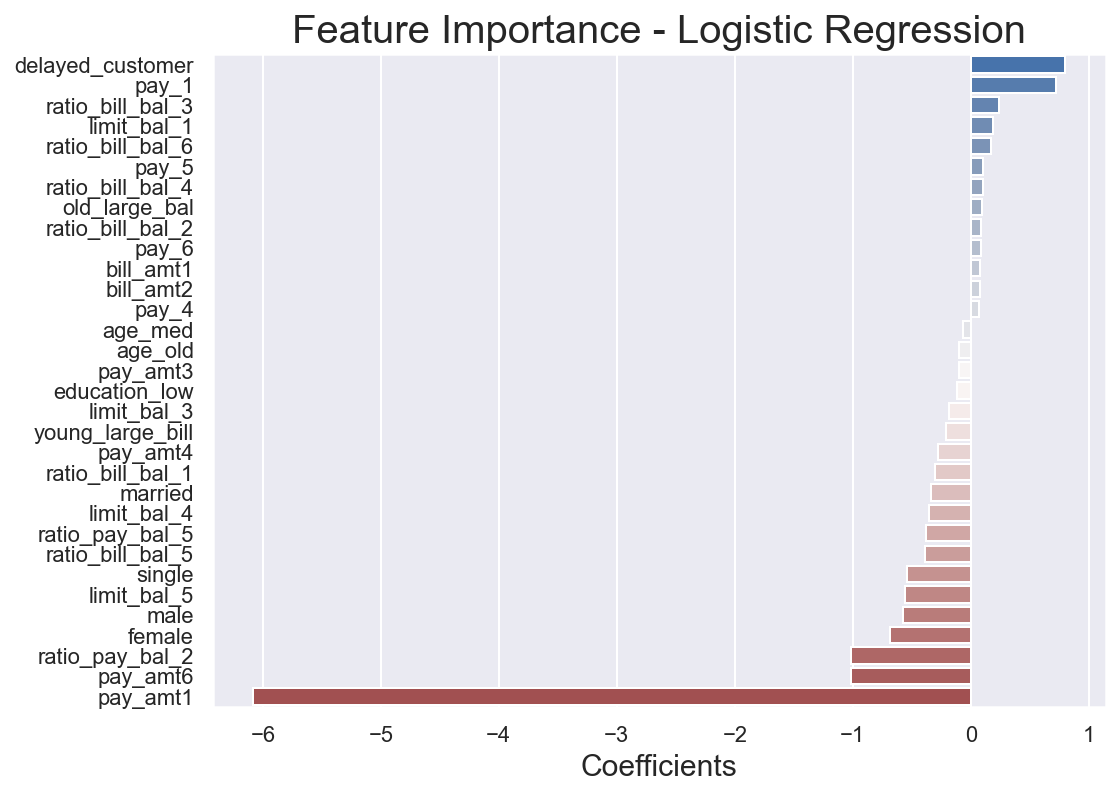

In [45]:
#Plot most important features and their values

plt.figure(figsize =  (8,6))
g = sns.barplot(data = coefs_sorted, y = 'feature', x = 'feature_importance', palette = sns.color_palette("vlag", coefs_sorted.shape[0]))
g.set_ylabel("")
g.tick_params(labelsize = 11)
g.set_xlabel("Coefficients", size = 15)
g.set_title('Feature Importance - Logistic Regression', size = 20)

In [46]:
#Prepare for modeling by only including these features in the final dataset

X = X[coefs_sorted['feature'].values]
X.shape
X.head()

(28444, 32)

,delayed_customer,pay_1,ratio_bill_bal_3,limit_bal_1,ratio_bill_bal_6,pay_5,ratio_bill_bal_4,old_large_bal,ratio_bill_bal_2,pay_6,bill_amt1,bill_amt2,pay_4,age_med,age_old,pay_amt3,education_low,limit_bal_3,young_large_bill,pay_amt4,ratio_bill_bal_1,married,limit_bal_4,ratio_pay_bal_5,ratio_bill_bal_5,single,limit_bal_5,male,female,ratio_pay_bal_2,pay_amt6,pay_amt1
0,1,2,0.03,1,0.00,0,0.00,0,0.16,0,-0.666219,-0.674440,0,0,0,0.000000,0,0,0,0.000000,0.20,1,0,0.00,0.00,0,0,0,1,0.03,0.000000,0.000000
1,1,0,0.02,0,0.03,0,0.03,0,0.01,2,-0.682710,-0.693530,0,0,0,0.001116,0,1,0,0.001610,0.02,0,0,0.00,0.03,1,0,0,1,0.01,0.003783,0.000000
2,0,0,0.15,0,0.17,0,0.16,0,0.16,0,-0.326931,-0.522979,0,1,0,0.001116,0,0,0,0.001610,0.32,0,0,0.01,0.17,1,0,0,1,0.02,0.009458,0.001738
3,0,0,0.99,1,0.59,0,0.57,0,0.96,0,-0.089123,-0.048758,0,1,0,0.001339,0,0,0,0.001771,0.94,1,0,0.02,0.58,0,0,0,1,0.04,0.001892,0.002290
4,0,0,0.72,1,0.38,0,0.42,0,0.11,0,-0.603200,-0.638838,0,0,1,0.011160,0,0,0,0.014493,0.17,1,0,0.01,0.38,0,0,1,0,0.73,0.001284,0.002290


## Model Fitting & Evaluation

Now I will split the dataset into testing and training sets so that the model can be evaluated on unseen data and be capable of generalizing to new data. With more time I would also create a validation set to perform cross-validation and tune the model hyperparameters.

I will use a stratified train/test split so that I sample the imbalanced target in both sets equally and I will use a split ratio of 70:30. In this case I will also undersample the more populated target ("no default") such that my training set is balanced with respect to default/no default customers. While this does reduce the number of total training samples, it should significantly improve the performance of the model in discerning between the two targets.

In [47]:
#Split data into 70% training and 30% testing while stratifying the target.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [48]:
#Undersample the majority class so that the training set is balanced.

undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [49]:
#I will keep track of the ROC curves and AUC for each model

models = dict()

In [50]:
#Train logistic regression model using new training data
#Run 5-fold cross validation to optimize for AUC for ROC

name = 'Logistic Regression'
clf = LogisticRegression(solver='liblinear')
params = [{'penalty': ('l1', 'l2'),
           'C': (0.01, 0.1, 1.0, 10)}]
gcv = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring={'AUC': 'roc_auc', 'Recall': 'recall'}, refit='AUC')
gcv.fit(X_train, y_train)
y_pred = gcv.predict(X_test)

#Save output to dictionary and print parameters/metrics
models[name] = gcv

print(gcv.best_estimator_)
print(classification_report(y_test, y_pred))

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid=[{'C': (0.01, 0.1, 1.0, 10), 'penalty': ('l1', 'l2')}],
             refit='AUC', scoring={'AUC': 'roc_auc', 'Recall': 'recall'})

LogisticRegression(C=10, penalty='l1', solver='liblinear')
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      6713
           1       0.45      0.58      0.51      1821

    accuracy                           0.76      8534
   macro avg       0.66      0.70      0.68      8534
weighted avg       0.79      0.76      0.77      8534



In [51]:
#Train random forest model using new training data
#Run 5-fold cross validation to optimize for AUC for ROC

name = 'Random Forest'
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
params = [{ 
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 6],
    'max_depth' : [4, 6, 8]
}]
gcv = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring={'AUC': 'roc_auc', 'Recall': 'recall'}, refit='AUC')
gcv.fit(X_train, y_train)
y_pred = gcv.predict(X_test)

#Save output to dictionary and print parameters/metrics
models[name] = gcv

print(gcv.best_estimator_)
print(classification_report(y_test, y_pred))

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1),
             param_grid=[{'max_depth': [4, 6, 8], 'min_samples_leaf': [2, 4, 6],
                          'min_samples_split': [2, 4, 6]}],
             refit='AUC', scoring={'AUC': 'roc_auc', 'Recall': 'recall'})

RandomForestClassifier(max_depth=8, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=200, n_jobs=-1)
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      6713
           1       0.45      0.61      0.52      1821

    accuracy                           0.76      8534
   macro avg       0.67      0.70      0.68      8534
weighted avg       0.79      0.76      0.77      8534



In [52]:
#Train gradient boosting model using new training data
#Run 5-fold cross validation to optimize for AUC for ROC

name = 'Gradient Boosting'
clf = GradientBoostingClassifier(n_estimators=200)
params = [{ 
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 6],
    'max_depth' : [4, 6, 8]
}]
gcv = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring={'AUC': 'roc_auc', 'Recall': 'recall'}, refit='AUC')
gcv.fit(X_train, y_train)
y_pred = gcv.predict(X_test)

#Save output to dictionary and print parameters/metrics
models[name] = gcv

print(gcv.best_estimator_)
print(classification_report(y_test, y_pred))

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(n_estimators=200),
             param_grid=[{'max_depth': [4, 6, 8], 'min_samples_leaf': [2, 4, 6],
                          'min_samples_split': [2, 4, 6]}],
             refit='AUC', scoring={'AUC': 'roc_auc', 'Recall': 'recall'})

GradientBoostingClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=6,
                           n_estimators=200)
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      6713
           1       0.42      0.64      0.51      1821

    accuracy                           0.73      8534
   macro avg       0.65      0.70      0.66      8534
weighted avg       0.79      0.73      0.75      8534



[(-0.05, 1.05),
 (-0.05, 1.05),
 Text(0.5, 1.0, 'Receiver Operating Characteristic')]

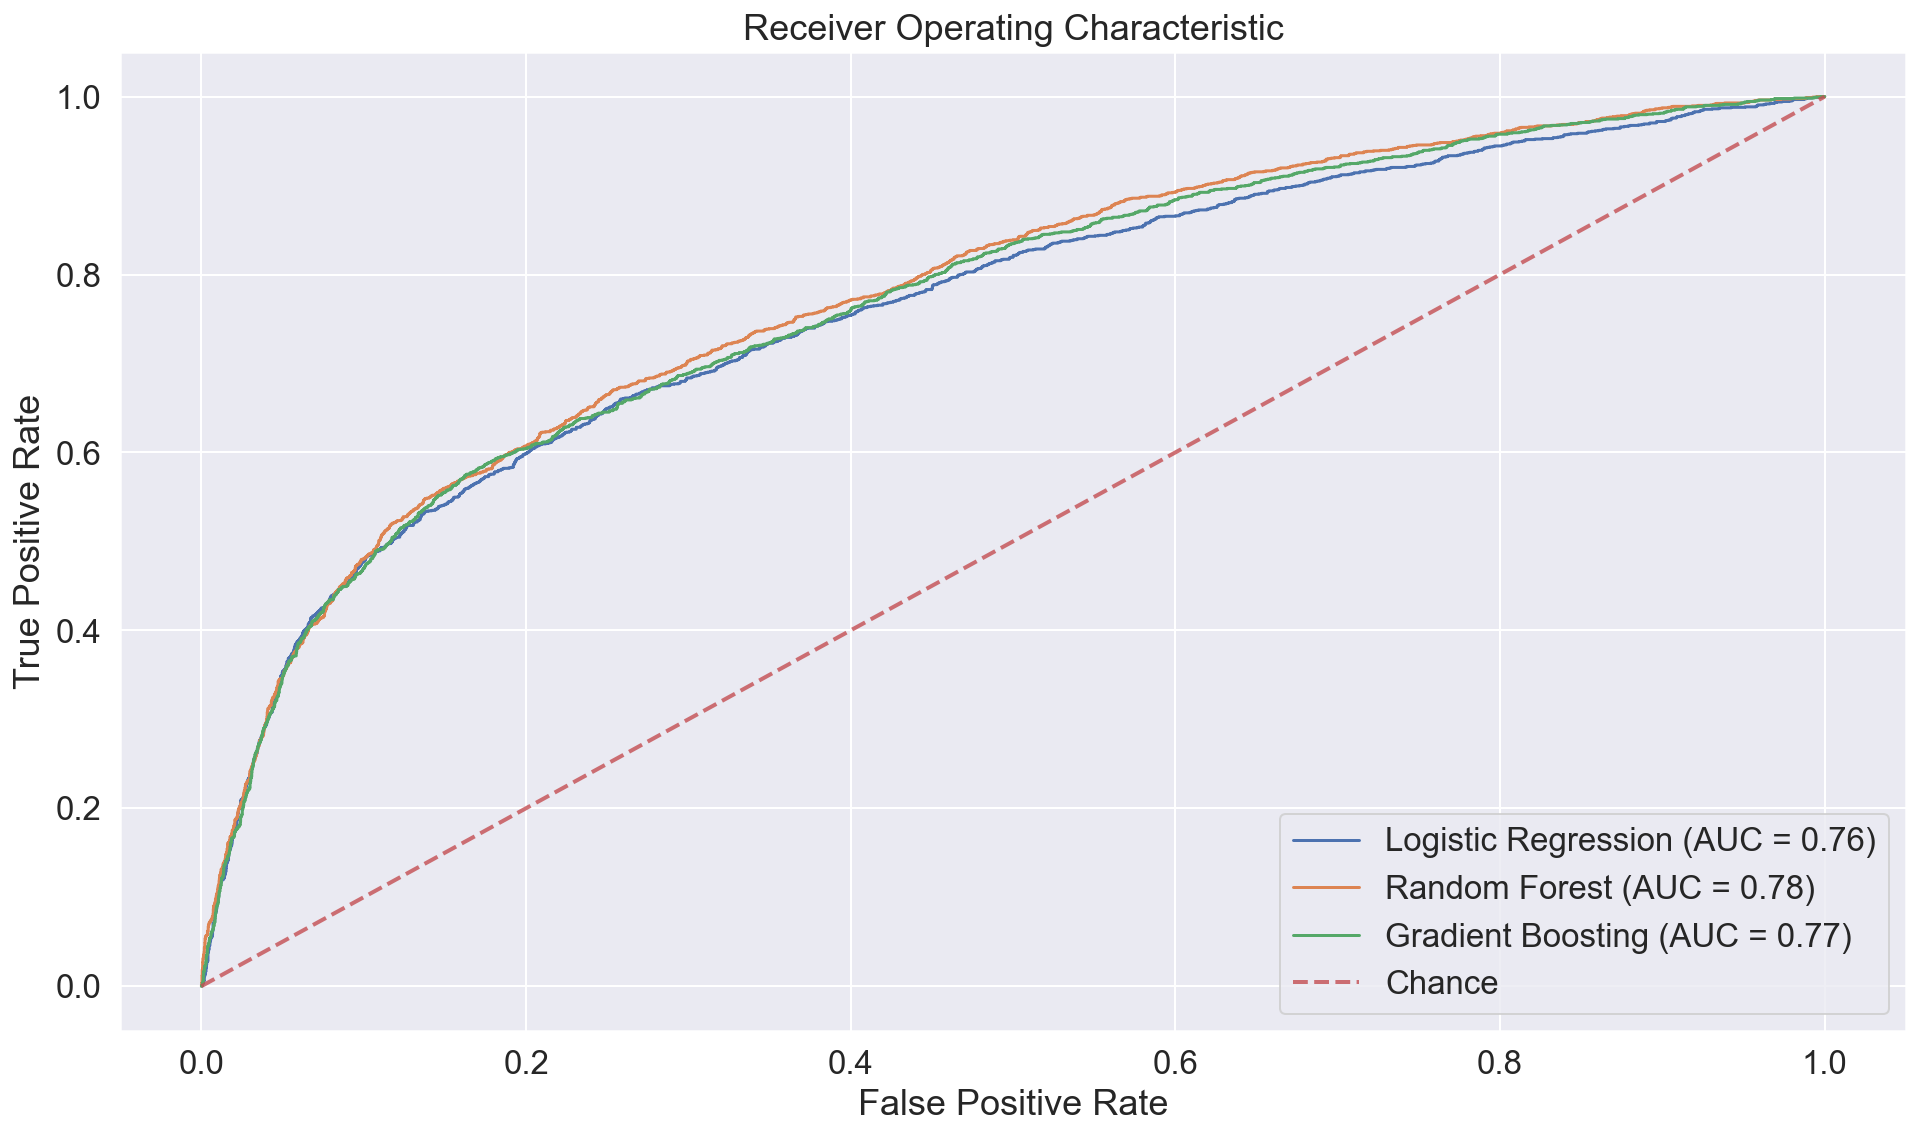

In [53]:
#Plot ROC curves for each model and random chance model

fig, ax = plt.subplots()

for model in models:
    plot_roc_curve(models[model], X_test, y_test, name=model, ax=ax)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

In [54]:
#Random forest appears to perform best and I will go into more depth in the next section.
#Here I will look at feature importance for this final random forest model.

clf = models['Random Forest'].best_estimator_
coefs = pd.DataFrame(clf.feature_importances_, columns=['feature_importance'])
coefs['feature'] = X_train.columns

coefs_sorted = coefs.sort_values(by='feature_importance', ascending=False, ignore_index=True)

#10 most important features (which can be positively or negatively related to default)
coefs_sorted.head(10)

,feature_importance,feature
0,0.210722,pay_1
1,0.210638,delayed_customer
2,0.058095,pay_4
3,0.045352,pay_5
4,0.043932,pay_amt1
5,0.034659,bill_amt1
6,0.032763,ratio_bill_bal_2
7,0.032610,pay_amt3
8,0.031764,pay_amt4
9,0.031482,bill_amt2


## Summary & Business Value

### Summary

I have built 3 models to predict the likelihood of default and which can generalize to new data. They are all capable of predicting probabilities of default/no default and their decisions can in general be explained. During training of these models, 5-fold cross validation was performed and the AUC of ROC was the optimized metric.

The final plot of ROC curves for each model show that they all perform relatively similarly across the threshold values. Random forest does have the highest AUC of 0.78 and slightly outperforms the other 2 models across the range of threshold values.
- Since the gradient boosting model required 12x more time to train and produced no clear predictive advantage, I would not recommend using it in production.
- The logistic regression model was 20x faster during training than random forest, although it has a lower AUC and performs worse in regions of low threshold/high recall (which is where the credit company likely wants to be).

In **summary**, I would currently advise the company to put the random forest model into production because:
- **Fast**: It still trained relatively quickly (51 seconds)
- **High Performance**: AUC of 0.78 and Recall of 0.61 (for default threshold)
- **Explainable**: Individual decision trees can be visualized and feature importance can be analyzed

### Use Cases

For **use cases** within a credit card company, I can provide actionable insights using the model's feature importance and ROC curve:

**Feature Importance**:
- The pay_ features appear to be very important as these define the current repayment status. The repayment status for the prior month (pay_1) is a strong indicator for default/no default.
- The delayed_customer feature is also a very strong predictor in this model. If a customer had a payment delay for 2+ months in the last 6 months, then it is likely that they can default in the next month. This highlights customers who are struggling to make timely payments.
- Payment amount, bill amount, and ratio of bill/balance are also strong predictors of default/no default. These also make intuitive sense because customers who make small payments, have large bills, and who have high ratios of credit line usage are all at risk of defaulting in the near future.
- In each of these cases, the company can potentially reach out to these customers who are at high risk of default and propose special repayment plans (such as installments) to avoid loss.

**ROC Curve**:
- I can use the cutoff thresholds and related recalls to calculated expected profit/loss. For example, given a threshold for determining default/no default, I can determine the model's recall which is directly related to the number of false negatives that will be predicted for the next month. If I know the number of false negatives (number of approved customers that will default), I can use the their balances to quantify the amount of expected loss to the company. Combining this with the expected gain from credit card interest, repayments, etc. will allow me to forecast net profit.

In general, credit card companies can use many of the feature engineering and model tuning provided in this exercise for their own credit products. Because these models output probabilities, they can also easily be extended to other business use cases such as credit card fraud detection (since this is a similar binary classification task). The assumption is that credit card transactions which are fraudulent are also rare and lead to an imbalanced dataset. This would require labeled data for historical fraudulent cases in the company.

These models could also be used to output **real-time** probability predictions of default for a given customer or batch of customers. In a production environment, incoming data can be evaluated by these models in full (if the data is small) or streamed in batches (if the data is big) so that the company can apply mitigation techniques as soon as possible.

## Next Steps

If this model was to be set into production and performed very poorly, I would look to engineer new features that hold more predictive power. If I was working at a credit card company, I would presumably have access to more customer data that could help create features that lead to better model performance:
- Credit score (FICO): can be obtained from credit bureaus and/or predicted in-house
- Credit history: can use even more historical data (12-24 months) to place customer in a behavioral group
- Risk score: create custom risk score based on spending behavior and demographic information
- Cluster feature: use unsupervised methods to cluster similar customers and make that a feature
- New customers: for customers with no payment history, I could process their demographic and behavioral information then use collaborative filtering with those customers who do have a payment history
- Temporal features: consider holiday spending and how Taiwanese holidays might impact monthly spending

With more time I would want to investigate other models:
- **K-Means**: unsupervised model which can be used for customer segmentation. Useful for feature engineering and helping group customers with little data
- **K-Nearest Neighbors**: useful for classification, I could use inverse distance as a weight, the probability of a class is then directly proportional to the inverse distance to neighbors
- **Support Vector Classifier**: useful for classification, I can get probability of a class by using logistic function and distance of point to SV hyperplane

Other miscellaneous things to try with more time:
- Try data sampling methods other than undersampling majority class (oversampling, SMOTE, etc.)
- Tune more hyperparameters during grid search cross validation
- Tune train/test split ratio

**THANK YOU!**